# **Preprocessing with SKLearn**

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import os
data = pd.read_csv("Titanic_0.csv"))
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


The `titanic` dataset contains both categorical, text, and numeric features. We will use this dataset to predict whether a passenger survived the Titanic or not. 

Let's split the data into training and testing sets and use the `Survived` column as a target.

In [5]:
y = data['Survived']
X = data.drop(columns='Survived')

In [6]:
X.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            141
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          549
Embarked         1
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [8]:
X_train.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            108
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          411
Embarked         1
dtype: int64

In [9]:
X_train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [10]:
X_train[['Sex', 'Embarked']]

,Sex,Embarked
116,male,S
131,male,S
589,female,S
27,male,S
595,male,S
...,...,...
659,female,S
256,male,S
643,male,C
249,female,C


Most of the classifiers are designed to work with numerical data. Therefore, we need to convert the categorical data into numeric features. The simplest way is to one-hot encode each categorical feature with the `OneHotEncoder`. Let's give an example for the `Sex` and `Embarked` columns. Note that we also encounter some data which are missing. We will use a `SimpleImputer` to replace the missing values with a constant values.

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

ohe = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
X_encoded = ohe.fit_transform(X_train[['Sex', 'Embarked']])
X_encoded.toarray()

array([[0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.]])

In [12]:
X_encoded

<534x6 sparse matrix of type '<class 'numpy.float64'>'
	with 1068 stored elements in Compressed Sparse Row format>

This way, it is possible to encode the categorical features. However, we also want to standardize the numerical features. Thus, we need to split the original data into 2 subgroups and apply a different preprocessing: (i) one-hot encoding for the categorical data and (ii) standard scaling for the numerical data. We also need to handle missing values in both cases. For the categorical column, we replace the missing values by the string `'missing_values'` which will be interpreted as a category on its own. For the numerical data, we will replace the missing data by the mean values of the feature of interest.

In [13]:
col_cat = ['Sex', 'Embarked']
col_num = ['Age', 'SibSp', 'Parch', 'Fare']

X_train_cat = X_train[col_cat]
X_train_num = X_train[col_num]
X_test_cat = X_test[col_cat]
X_test_num = X_test[col_num]

In [14]:
from sklearn.preprocessing import StandardScaler

scaler_cat = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
X_train_cat_enc = scaler_cat.fit_transform(X_train_cat)
X_test_cat_enc = scaler_cat.transform(X_test_cat)

scaler_num = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
X_train_num_scaled = scaler_num.fit_transform(X_train_num)
X_test_num_scaled = scaler_num.transform(X_test_num)

In [15]:
X_train_cat_enc

<534x6 sparse matrix of type '<class 'numpy.float64'>'
	with 1068 stored elements in Compressed Sparse Row format>

In [16]:
X_train_num_scaled

array([[-0.84978858,  0.42402614,  0.65645945,  0.06750954],
       [-1.00181375, -0.48169369, -0.45639562, -0.46804832],
       [ 1.35457638,  0.42402614,  2.88216959,  0.02222428],
       ...,
       [-2.26210241, -0.48169369,  0.65645945, -0.47082836],
       [-0.92580117,  1.32974597,  1.76931452,  4.36960987],
       [-1.15383892,  0.42402614, -0.45639562, -0.35761519]])

In [17]:
type(X_train_num_scaled)

numpy.ndarray

In [18]:
from scipy import sparse
sparse.csr_matrix(X_train_num_scaled)

<534x4 sparse matrix of type '<class 'numpy.float64'>'
	with 2028 stored elements in Compressed Sparse Row format>

We should apply these transformations on the training and testing sets

In [19]:
import numpy as np
from scipy import sparse

X_train_scaled = sparse.hstack((X_train_cat_enc, sparse.csr_matrix(X_train_num_scaled)))
X_test_scaled = sparse.hstack((X_test_cat_enc, sparse.csr_matrix(X_test_num_scaled)))

### `sparse.hstack():`  Stack sparse-matrices horizontally, Adding them beside each other(column wise)

>h means horizontal

### `sparse.vstack():`  Stack sparse-matrices vertically, Adding them on top of each other(row wise)

>v means vertical

### `sparse.csr_matrix():` Compressed Sparse Row matrix

> These are Scipi matrices instead of Numpy, they're faster

Once the transformation is done, we can combine the informations which are all numerical now. Finally, we use our `LogisticRegression` classifier as a model.

In [20]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train_scaled, y_train)
accuracy = clf.score(X_test_scaled, y_test)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__, accuracy))

Accuracy score of the LogisticRegression is 0.74


The above pattern of first transforming the data and then fitting/scoring the classifier is exactly the one we saw before. Therefore, we would like to use a pipeline for such purpose. However, we would also like to have different processing on different columns of our matrix. The `ColumnTransformer` transformer or the `make_column_transformer` function should be used. It is used to automatically apply different pipeline on different columns.

In [21]:
from sklearn.compose import make_column_transformer

col_cat = ['Sex', 'Embarked']
col_num = ['Age', 'SibSp', 'Parch', 'Fare']

pipe_cat = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))
pipe_num = make_pipeline(SimpleImputer(), StandardScaler())

preprocessor = make_column_transformer((pipe_cat, col_cat), (pipe_num, col_num))

pipe = make_pipeline(preprocessor, LogisticRegression(solver='lbfgs'))

pipe.fit(X_train, y_train)
accuracy = pipe.score(X_test, y_test)
print('Accuracy score of the {} is {:.2f}'.format(pipe.__class__.__name__, accuracy))

Accuracy score of the Pipeline is 0.74


In [22]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
708,709,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
709,710,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
710,711,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
711,712,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [23]:
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, KBinsDiscretizer, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier



# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['SibSp', 'Parch', 'Fare']
categorical_features = ['Embarked', 'Sex', 'Pclass',]
age_feaututre = ['Age']

numeric_transformer = make_pipeline( SimpleImputer(strategy='mean'), StandardScaler(), PolynomialFeatures(degree = 3) ) 
categorical_transformer = make_pipeline( SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore') )
age_transformer =  make_pipeline( SimpleImputer(strategy='mean'), KBinsDiscretizer(strategy = 'uniform') ) 

preprocessor = make_column_transformer( 
        ( numeric_transformer, numeric_features),
        ( categorical_transformer, categorical_features),
        ( age_transformer, age_feaututre)
        )
                                        
pipelgbm = make_pipeline( preprocessor, LGBMClassifier() , verbose = 1) 
pipelgbm.fit(X_train, y_train)
accuracy = pipelgbm.score(X_test, y_test)
print('Accuracy score of the {} is {:.2f}'.format(pipe.__class__.__name__, accuracy))

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 2) Processing lgbmclassifier, total=   0.1s
Accuracy score of the Pipeline is 0.79


Besides, it can also be used in another pipeline. Thus, we will be able to use all `scikit-learn` utilities as `cross_validate` or `GridSearchCV`.

In [24]:
pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                     transformer_weights=None,
                     transformers=[('pipeline-1',
                                    Pipeline(memory=None,
                                             steps=[('simpleimputer',
                                                     SimpleImputer(add_indicator=False,
                                                                   copy=True,
                                                                   fill_value=None,
                                                                   missing_values=nan,
                                                                   strategy='constant',
                                                                   verbose=0)),
                                                    ('onehotencoder',
                                                     OneHotEncoder(categorie

In [25]:
plt.style.use('dark_background')

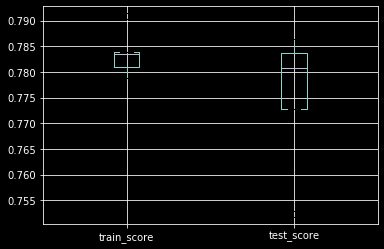

In [26]:
from sklearn.preprocessing import MinMaxScaler,  RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

pipe_cat = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))
pipe_num = make_pipeline(StandardScaler(), SimpleImputer())

preprocessor = make_column_transformer((pipe_cat, col_cat), (pipe_num, col_num))

pipe = make_pipeline(preprocessor, LogisticRegression(solver='lbfgs'))

param_grid = {'columntransformer__pipeline-2__simpleimputer__strategy': ['mean', 'median'],
              'logisticregression__C': [0.1, 1.0, 10],
              'columntransformer__pipeline-2__standardscaler' : [MinMaxScaler(), RobustScaler() ] }

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)

scores = pd.DataFrame(cross_validate(grid, X, y, scoring='balanced_accuracy', cv=5, n_jobs=-1, return_train_score=True))
scores[['train_score', 'test_score']].boxplot()

### columntransformer__:

- inside columntransformner

### pipeline-2:
- means second pipeline (pipe_num)

### simpleimputer:

- simpleimputer of the second pipeline

### strategy:

- set the strategy for the simpleiputer

### Balanced accuracy:
    
- is calculated as the average of the proportion corrects of each class individually.

In [27]:
scores

,fit_time,score_time,test_score,train_score
0,1.756175,0.000000,0.780682,0.780989
1,1.772797,0.000000,0.786364,0.783830
2,1.849962,0.005984,0.772727,0.783504
3,1.794112,0.005985,0.752315,0.790823
4,1.828635,0.000000,0.783670,0.778850


In [28]:
grid.fit(X_test, y_test).best_params_

{'columntransformer__pipeline-2__simpleimputer__strategy': 'mean',
 'columntransformer__pipeline-2__standardscaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'logisticregression__C': 1.0}

# Exercise

Do the following exercise:

Load the adult dataset located in `./data/adult_openml.csv`. Make your own `ColumnTransformer` preprocessor. Pipeline it with a classifier. Fine tune it and check the prediction accuracy within a cross-validation.

* Read the adult dataset located in `./data/adult_openml.csv` using `pd.read_csv`.

In [30]:
#data2 = pd.read_csv(os.path.join('data', 'adult_openml.csv'))
data2 = pd.read_csv(r"adult_openml.csv")

In [31]:
data2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K


* Split the datasets into a data and a target. The target corresponds to the `class` column. For the data, drop the columns `fnlwgt`, `capitalgain`, and `capitalloss`.

In [32]:
target = data2['class']
data = data2.drop(columns=['class', 'fnlwgt', 'capitalgain', 'capitalloss'])


* The target is not encoded. Use the `sklearn.preprocessing.LabelEncoder` to encode the class.

In [33]:
from sklearn.preprocessing import LabelEncoder

target = LabelEncoder().fit_transform(target)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data, target, stratify = target)

* Create a list containing the name of the categorical columns. Similarly, do the same for the numerical data.

In [35]:
col_cat = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'sex']
col_num = ['age', 'hoursperweek']


* Create a pipeline to one-hot encode the categorical data. Use the `KBinsDiscretizer` for the numerical data. Import it from `sklearn.preprocessing`.

In [36]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer

pipe_cat = OneHotEncoder(handle_unknown='ignore')
pipe_num = KBinsDiscretizer(strategy = 'uniform')


* Create a `preprocessor` by using the `make_column_transformer`. You should apply the right pipeline to the right column.

In [37]:
from sklearn.compose import make_column_transformer

preprocessor = make_column_transformer((pipe_cat, col_cat), (pipe_num, col_num))


* Pipeline the preprocessor with a `LogisticRegression` classifier. Subsequently define a grid-search to find the best parameter `C`. Train and test this workflow in a cross-validation scheme using `cross_validate`.

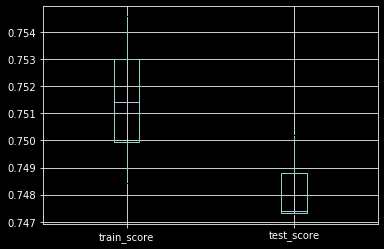

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

pipe = make_pipeline(preprocessor, LogisticRegression(solver='lbfgs', max_iter=1000))

param_grid = {'logisticregression__C': [0.1, 1.0, 10]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

scores = pd.DataFrame(cross_validate(grid, data, target, scoring='balanced_accuracy', cv=3, n_jobs=-1, return_train_score=True))
scores[['train_score', 'test_score']].boxplot(whis=10)


### Another Estimatior(SVC)

In [49]:
pipe = make_pipeline(preprocessor, SVC())

param_grid = {'svc__C': [0.1, 1,10]
              #'svc__gamma': [0.1, 1, 10]
             }

grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1)

In [50]:
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

C:\Users\Behnam\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


0.83899762509213